In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 26a

##  Convolutional Neural Network (CNN) DenseNet
<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

<img src='../../images/dense_net.png' style = 'width:1200px;' alt="densenet" align="left"/>

In [2]:
### Import Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

from utils.helper import fn_plot_confusion_matrix, fn_plot_tf_hist, fn_plot_labels

2024-12-27 09:11:58.805460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735270918.819177   22225 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735270918.822978   22225 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 09:11:58.838105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'utils'

In [3]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models'
valDir = 'valid_flowers'
altName = 'densenet_flowers'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

EPOCHS = 100 # number of cycles to run

BATCH_SIZE =32

ALPHA = 0.001
TEST_SIZE = 0.2
IMG_HEIGHT = 200
IMG_WIDTH = 200

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 
FILL_MODE = 'nearest'

ES_PATIENCE = 10 # if performance does not improve stop

LR_PATIENCE = 5 # if performance is not improving reduce alpha

LR_FACTOR = 0.8 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,4),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
print (physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-30 19:16:27.489927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 19:16:27.537827: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 19:16:27.538151: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Import Densenet

In [5]:
from tensorflow.keras.applications import DenseNet169

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [6]:
data_dir = os.path.join(inpDir, subDir)

In [7]:
data_dir

'../../input/flower_photos'

In [8]:
### For Colab Users only.

In [9]:
_ = '''import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)'''

In [10]:
# load data and split in training and validation from a sub dir

# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="training",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="validation",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2024-05-30 19:16:27.782510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 19:16:27.782798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 19:16:27.783016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
#!ls '../input/valid_flowers'

### Is it picking the class names?

In [12]:
class_names = {count: classn for count, classn in enumerate(train_ds.class_names)}
print('total ', len(class_names), class_names)

total  5 {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}


### Verify the data

To verify that the dataset looks correct, let's plot a batch from the training set and display the class name below each image.


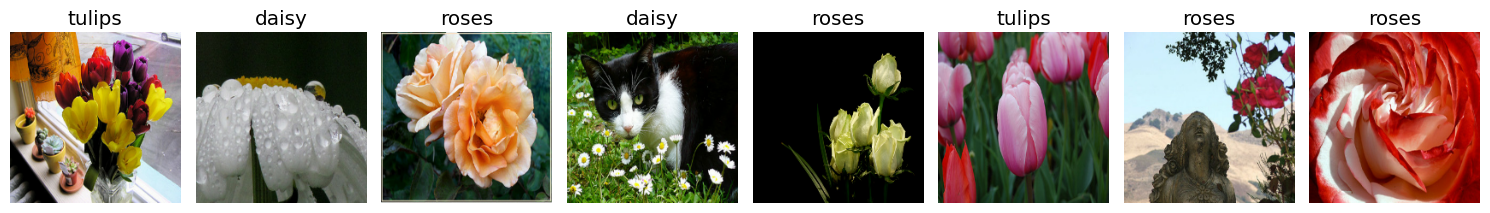

In [13]:
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(int(BATCH_SIZE/8), 8, i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float
        
        plt.title(class_names[labels[i].numpy()])
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

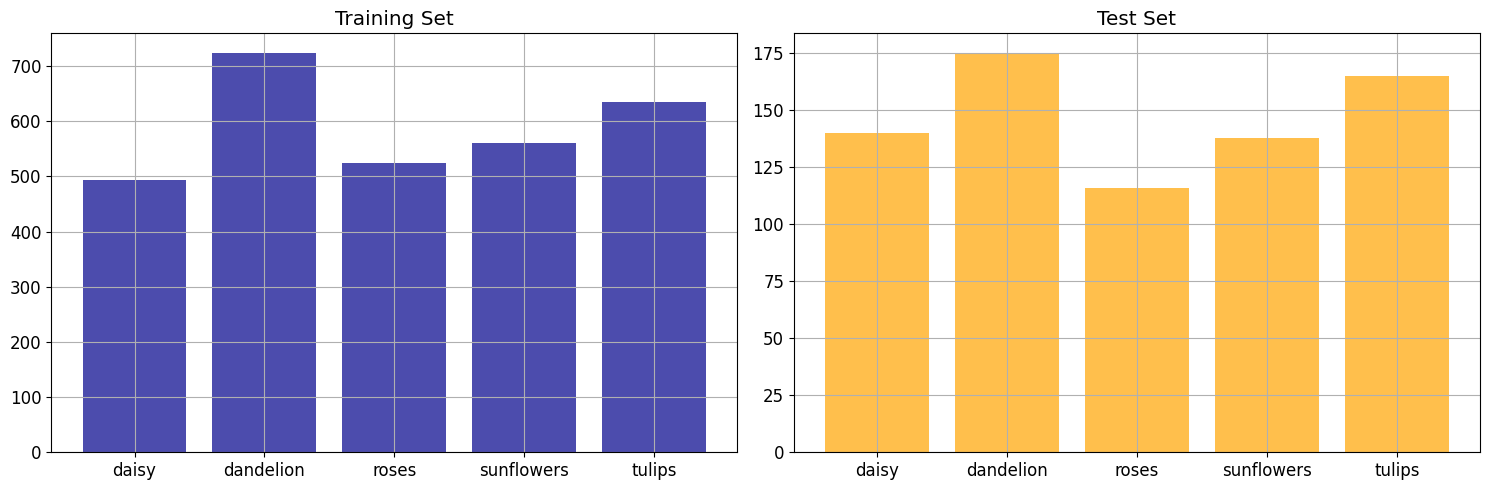

In [14]:
fn_plot_labels(train_ds, test_ds)

In [15]:
images[i].shape

TensorShape([200, 200, 3])

In [16]:
## Optimize for performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [17]:
densenet_model = tf.keras.applications.DenseNet169(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [18]:
for layer in densenet_model.layers:
    layer.trainable = False

In [19]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 206, 206, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 100, 100, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1/conv[0][0]']

In [20]:
num_classes = len(class_names)

In [23]:
# Create Model objecct
def build_model(d_model, n_classes):

    krnl_init = tf.keras.initializers.GlorotUniform(
                                       seed=RANDOM_STATE )


    model = tf.keras.Sequential()
    
    # Scaling all images between 0 and 1
    model.add(tf.keras.layers.Rescaling(1./255))

    # Data Augmentation
    #model.add(tf.keras.layers.RandomFlip(mode=FLIP_MODE, seed=RANDOM_STATE ))
    #model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR, fill_mode = FILL_MODE, seed=RANDOM_STATE ))

    
    model.add(densenet_model)  # 6x6 X 1664

    
    #model.add(tf.keras.layers.Dropout(0.1))

    #model.add(tf.keras.layers.Conv2D(1664, (3, 3),
    #                                 kernel_initializer = krnl_init,
    #                                 activation='relu'))   # 4x4
    # 

    #model.add(tf.keras.layers.Conv2D(5, (4, 4)))            # using 4x4 kernel to see the complete image

    model.add(tf.keras.layers.Flatten())

    # First Dense set
    model.add(tf.keras.layers.Dense(1664,
                                     kernel_initializer = krnl_init 
                                     ))
    
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Activation(activation='relu'))

    model.add(tf.keras.layers.Dropout(0.5))
    
    
    # Second Dense set
    model.add(tf.keras.layers.Dense(46,
                                     kernel_initializer = krnl_init, 
                                     ))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Activation(activation='relu'))

    model.add(tf.keras.layers.Dropout(0.5))
    
    
    # Output layer
    model.add(tf.keras.layers.Dense(n_classes,
                                  kernel_initializer = krnl_init
                                  ))

    #Using softmax activation function at the last layer which is used for multi class classification
    #model.add(tf.keras.layers.Activation('softmax'))

    return model

In [24]:
model = build_model(densenet_model,num_classes) 

In [25]:
# Directory where the checkpoints will be saved
checkpoint_dir = os.path.join(modelDir, subDir)

# Early Stopping
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)


# Reduction schedule for alpha
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=LR_FACTOR,
                                                 patience=LR_PATIENCE)


checkpoint_prefix = os.path.join(checkpoint_dir, altName)

# Save weights
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    callbacks=[ early_callback, lr_reduce], # model_callback
                    epochs=EPOCHS)

Epoch 1/100


2024-05-30 19:17:23.365401: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-30 19:17:26.876960: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d15b926b250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-30 19:17:26.877003: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-30 19:17:26.886262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717076846.983319    5693 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


367/367 [==============================] - 132s 330ms/step - loss: 0.8409 - accuracy: 0.7108 - val_loss: 0.3344 - val_accuracy: 0.8896 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - 117s 320ms/step - loss: 0.4458 - accuracy: 0.8607 - val_loss: 0.3058 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - 117s 319ms/step - loss: 0.2869 - accuracy: 0.9213 - val_loss: 0.2988 - val_accuracy: 0.8937 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - 117s 319ms/step - loss: 0.2177 - accuracy: 0.9401 - val_loss: 0.3253 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - 117s 319ms/step - loss: 0.1635 - accuracy: 0.9516 - val_loss: 0.2963 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - 194s 529ms/step - loss: 0.1483 - accuracy: 0.9544 - val_loss: 0.2920 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 7/100
367/367 [==============================]

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 6, 6, 1664)        12642880  
                                                                 
 flatten_1 (Flatten)         (None, 59904)             0         
                                                                 
 dense_1 (Dense)             (None, 1664)              99681920  
                                                                 
 batch_normalization_1 (Bat  (None, 1664)              6656      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 1664)              0         
                                                      

In [29]:
#tf.keras.utils.plot_model(model, "flowers_model.png")

In [30]:
res_df = pd.DataFrame(history.history)
res_df

loss  accuracy  val_loss  val_accuracy      lr
0   0.840919  0.710831  0.334381      0.889646  0.0010
1   0.445780  0.860695  0.305763      0.891008  0.0010
2   0.286875  0.921322  0.298790      0.893733  0.0010
3   0.217682  0.940054  0.325288      0.892371  0.0010
4   0.163522  0.951635  0.296336      0.901907  0.0010
5   0.148334  0.954360  0.291995      0.908719  0.0010
6   0.110978  0.963896  0.333504      0.901907  0.0010
7   0.087259  0.973774  0.330627      0.901907  0.0010
8   0.077634  0.980245  0.332942      0.905995  0.0010
9   0.071176  0.979905  0.376726      0.892371  0.0010
10  0.078676  0.975817  0.502251      0.869210  0.0010
11  0.079370  0.973433  0.381785      0.893733  0.0008
12  0.057252  0.983992  0.389889      0.899183  0.0008
13  0.047143  0.987057  0.386447      0.904632  0.0008
14  0.037185  0.990123  0.458929      0.891008  0.0008
15  0.045513  0.986035  0.442148      0.899183  0.0008

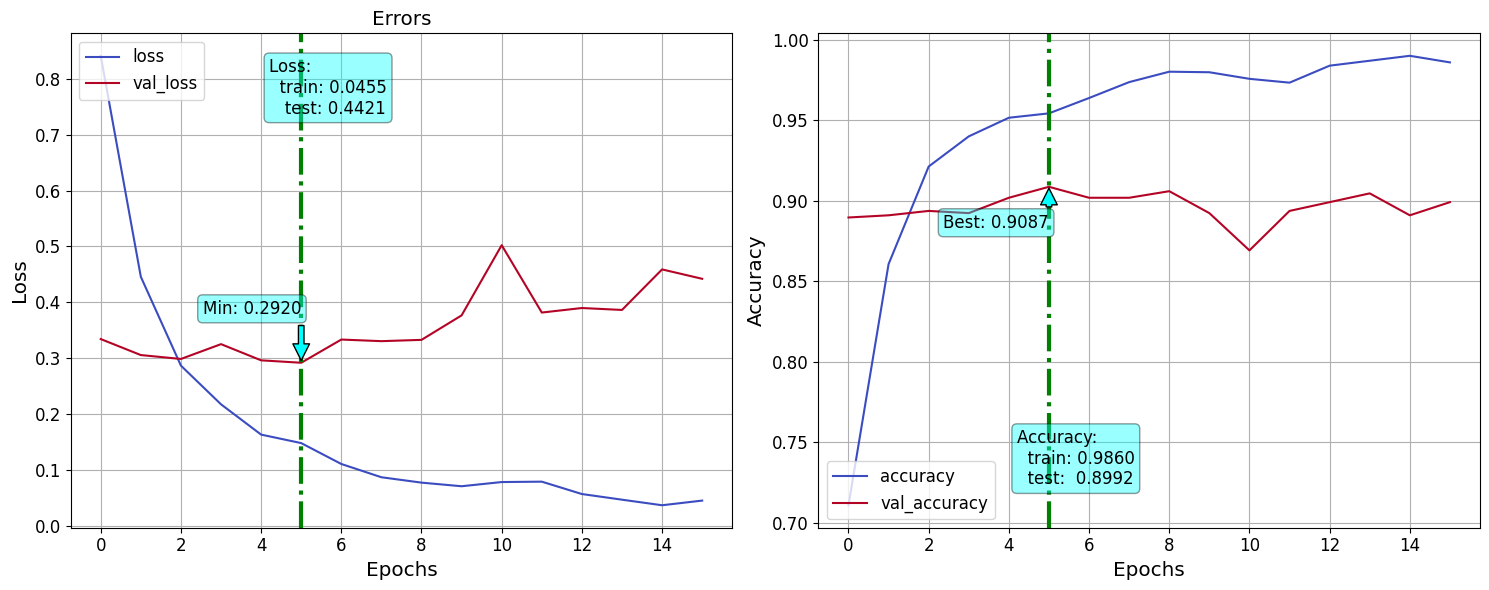

In [31]:
fn_plot_tf_hist(res_df)

### Evaluate the model

In [32]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

92/92 [==============================] - 3s 28ms/step - loss: 0.2920 - accuracy: 0.9087


In [33]:
yhat = model.predict(test_ds)

92/92 [==============================] - 4s 27ms/step


In [34]:
y_test = np.concatenate([y for X, y in test_ds], axis=0).squeeze()

In [35]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score on Test Data : 0.9087


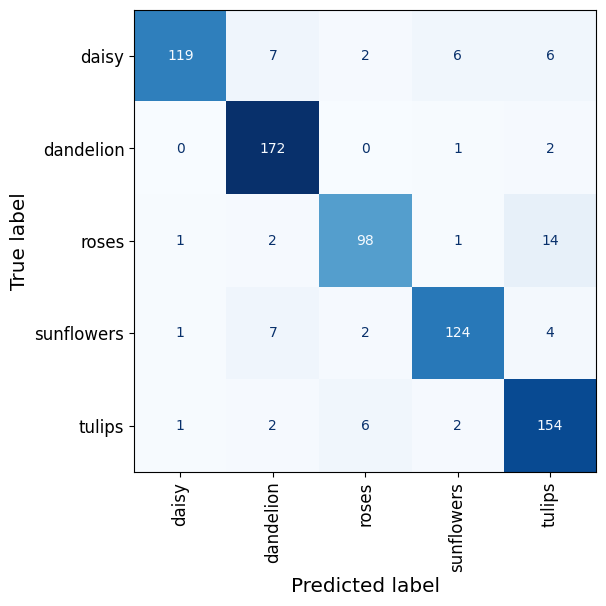

In [36]:
fn_plot_confusion_matrix(y_test, y_pred, class_names)

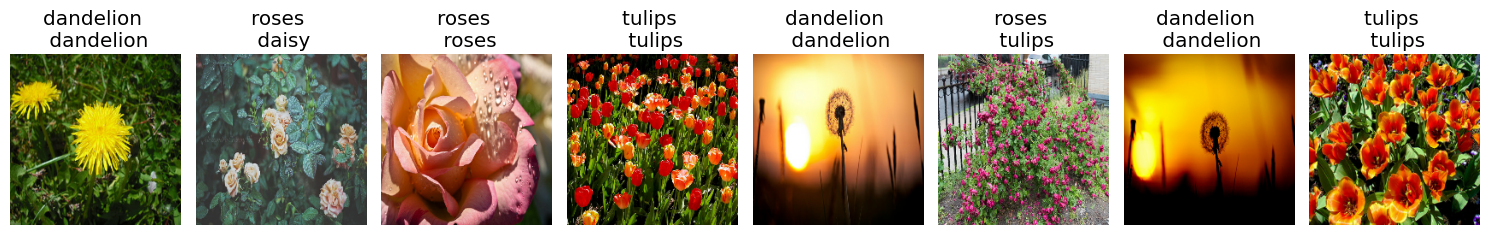

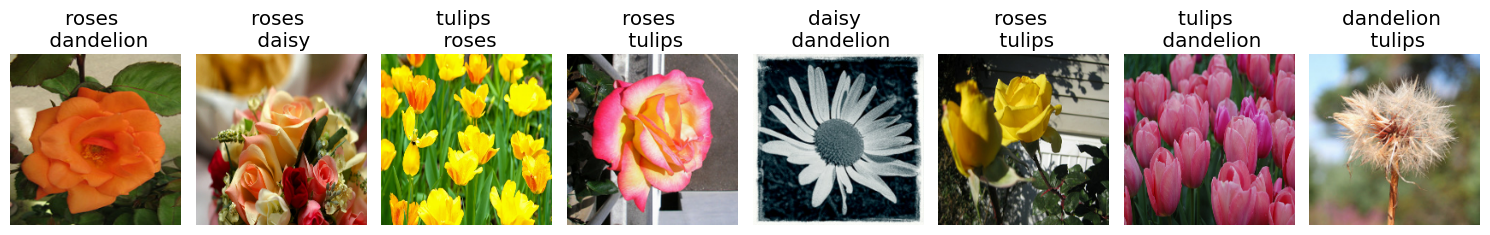

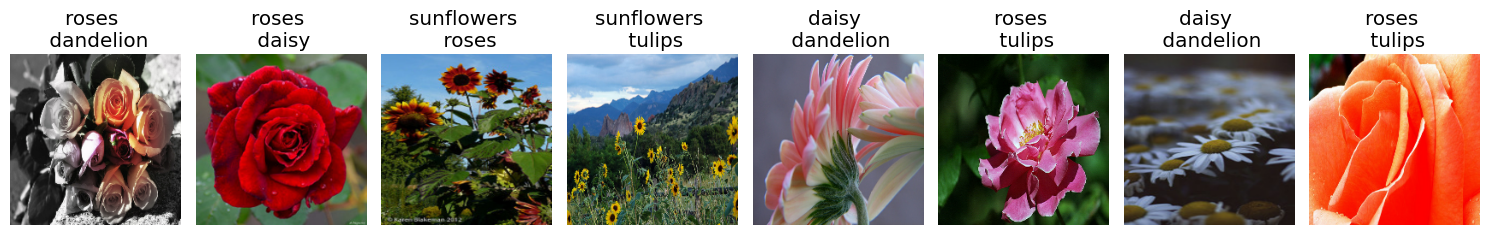

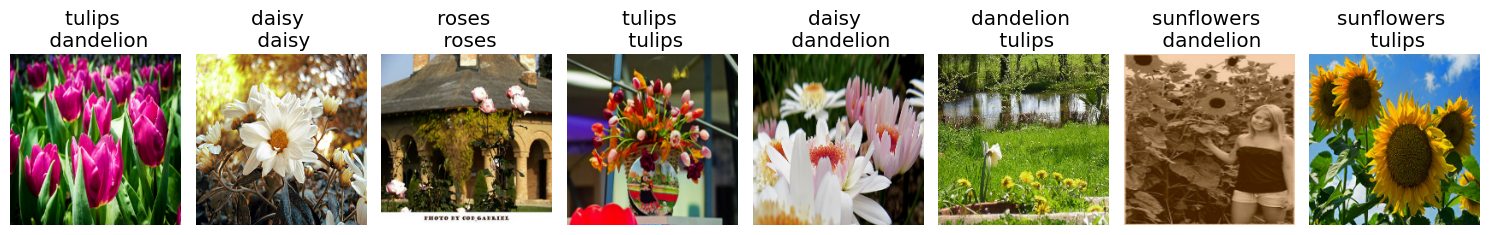

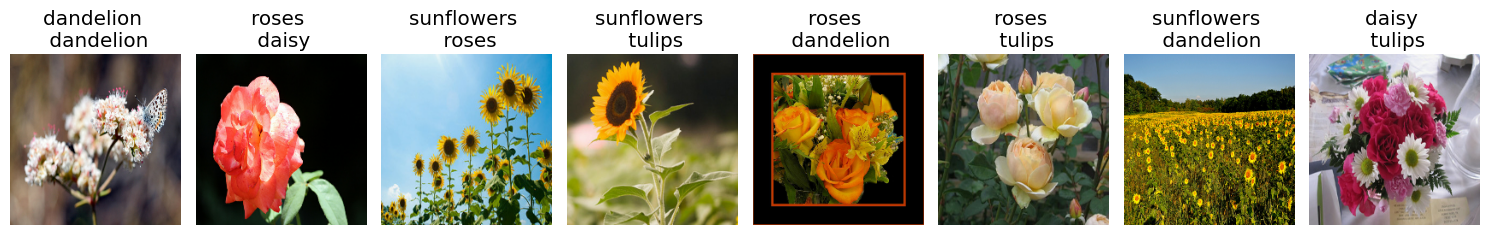

In [37]:
for images, labels in test_ds.take( 5 ):
    
    for i in range ( BATCH_SIZE ):
        
        plt.subplot(int( BATCH_SIZE / 8 ), 8, i+1 )
        
        plt.grid(False)
        
        plt.imshow ( images[i].numpy().astype('uint16'))
        
        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))
        
        plt.axis("off")
        
    plt.tight_layout()
    
    plt.show()

In [40]:
# model_path = checkpoint_prefix+'.keras'
# model.save(model_path)

# new_model = tf.keras.models.load_model(model_path)

# new_model.summary()

In [1]:
yhat = model.predict(test_ds)

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.4f}'.format( accuracy_score(y_test, y_pred)))

NameError: name 'model' is not defined

## Running on Validation Dataset

In [ ]:
val_dir = os.path.join(inpDir, valDir)



val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, 
                                                     validation_split=None, 
                                                     seed=RANDOM_STATE,
                                                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=BATCH_SIZE)

In [ ]:
plt.figure(figsize=(15,5))

for images, labels in val_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(int(BATCH_SIZE/8), 8, i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float
        
        plt.title(class_names[labels[i].numpy()])
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

In [ ]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
test_loss, test_acc = new_model.evaluate(val_ds, verbose=1)

In [ ]:
yhat = new_model.predict(val_ds)

y_pred = yhat.argmax(axis = 1)

y_test = np.concatenate([y for x, y in val_ds], axis=0).squeeze()

print('Accuracy score on Test Data :{:.4f}'.format(accuracy_score(y_test, y_pred)) )

In [ ]:
for images, labels in val_ds.take( 5 ):
    
    for i in range ( BATCH_SIZE ):
        
        plt.subplot(int( BATCH_SIZE / 8 ), 8, i+1 )
        
        plt.grid(False)
        
        plt.imshow ( images[i].numpy().astype("uint8"))
        
        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))
        
        plt.axis("off")
        
    plt.tight_layout()
    
    plt.show()